# Własne środowisko

### Autorzy:
Diana Misiaczyńska, Emilia Myrta

### simple_maze.py

Na początek dodajemy potrzebne importy.

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame

Nasze środowisko jest siatką o wymiarach 20 x 20.

In [2]:
class SimpleMazeEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode=None):
        super().__init__()
        self.grid_size = (20, 20)
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=max(self.grid_size)-1, shape=(2,), dtype=np.int32)
        self.grid = np.zeros(self.grid_size, dtype=int)
        self._generate_maze()
        self.agent_pos = [0, 0]
        self.render_mode = render_mode
        self.window = None
        self.clock = None

    def _generate_maze(self):
        self.grid[:] = 0
        self.grid[19, 19] = 9
        walls = [(i, 5) for i in range(1, 15)] + [(15, j) for j in range(5, 15)] + \
                [(i, 14) for i in range(5, 19)] + [(5, j) for j in range(6, 14)] + \
                [(10, j) for j in range(0, 10)] + [(j, 10) for j in range(11, 19)] + \
                [(8, 8), (8, 9), (8, 10), (8, 11), (12, 12), (13, 12), (14, 12), (15, 12)]
        for x, y in walls:
            self.grid[x, y] = 1
        for x, y in [(2, 2), (4, 18), (10, 16), (17, 1)]:
            self.grid[x, y] = 2
        for x, y in [(6, 6), (12, 7), (18, 10), (15, 3)]:
            self.grid[x, y] = 3

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._generate_maze()
        self.agent_pos = [0, 0]
        return np.array(self.agent_pos), {}

    def step(self, action):
        x, y = self.agent_pos
        if action == 0: y = max(0, y - 1)
        elif action == 1: y = min(self.grid_size[1] - 1, y + 1)
        elif action == 2: x = max(0, x - 1)
        elif action == 3: x = min(self.grid_size[0] - 1, x + 1)
        if self.grid[x, y] == 1: x, y = self.agent_pos
        self.agent_pos = [x, y]

        tile = self.grid[x, y]
        reward, done = -0.2, False
        if tile == 2:
            reward = 5
            self.grid[x, y] = 0
        elif tile == 3:
            reward = -2
        elif tile == 9:
            reward = 20
            done = True

        return np.array(self.agent_pos), reward, done, False, {}

    def render(self):
        tile_size = 25
        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode((self.grid_size[1] * tile_size, self.grid_size[0] * tile_size))
            pygame.display.set_caption("Maze Agent")
        if self.clock is None:
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.grid_size[1] * tile_size, self.grid_size[0] * tile_size))
        canvas.fill((255, 255, 255))
        colors = {0: (255, 255, 255), 1: (0, 0, 0), 2: (0, 255, 0), 3: (128, 0, 128), 9: (255, 0, 0)}
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                pygame.draw.rect(canvas, colors.get(self.grid[i, j], (200, 200, 200)),
                                 pygame.Rect(j * tile_size, i * tile_size, tile_size, tile_size))
        ax, ay = self.agent_pos
        pygame.draw.rect(canvas, (0, 0, 255), pygame.Rect(ay * tile_size, ax * tile_size, tile_size, tile_size))

        self.window.blit(canvas, (0, 0))
        pygame.display.update()

        self.clock.tick(5)

    def close(self):
        if self.window:
            pygame.quit()

### main.py

In [ ]:
import gymnasium as gym
import gymnasium_env
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
EPISODES = 1000
ALPHA = 0.1
GAMMA = 0.99
EPSILON = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MAX_STEPS = 500

In [ ]:
env = gym.make("SimpleMaze-v0")

grid_shape = env.unwrapped.grid_size
q_table = np.zeros((grid_shape[0], grid_shape[1], env.action_space.n))

rewards_per_episode = []

for episode in range(EPISODES):
    steps = 0
    state, _ = env.reset()
    # if (episode + 1) % 50 == 0:
    #     print(">>> Grid przed treningiem:")
    #     print(env.unwrapped.grid)

    done = False
    total_reward = 0
    recent_positions = []

    while not done and steps < MAX_STEPS:
        x, y = state

        if np.random.random() < EPSILON:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[x, y])

        next_state, reward, done, _, _ = env.step(action)

        recent_positions.append(tuple(next_state))
        if len(recent_positions) > 10:
            recent_positions.pop(0)
        if recent_positions.count(tuple(next_state)) > 4:
            reward -= 3

        nx, ny = next_state
        old_value = q_table[x, y, action]
        next_max = np.max(q_table[nx, ny])
        new_value = old_value + ALPHA * (reward + GAMMA * next_max - old_value)
        q_table[x, y, action] = new_value

        state = next_state
        total_reward += reward
        steps += 1

    EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 50 == 0:
        print(f"Epizod {episode + 1}, suma nagród: {total_reward:.2f}, epsilon: {EPSILON:.3f}")


In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


rolling_mean = moving_average(rewards_per_episode, 50)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode, label='Nagroda (epizod)')
plt.title("Nagrody w trakcie treningu")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rolling_mean, label='Średnia krocząca (50)', color='orange')
plt.title("Wygładzona średnia nagród")
plt.xlabel("Epizod")
plt.ylabel("Średnia nagroda")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

env = gym.make("SimpleMaze-v0", render_mode="human")
state, _ = env.reset()
done = False

while not done:
    env.render()
    x, y = state
    action = np.argmax(q_table[x, y])
    state, _, done, _, _ = env.step(action)

env.close()

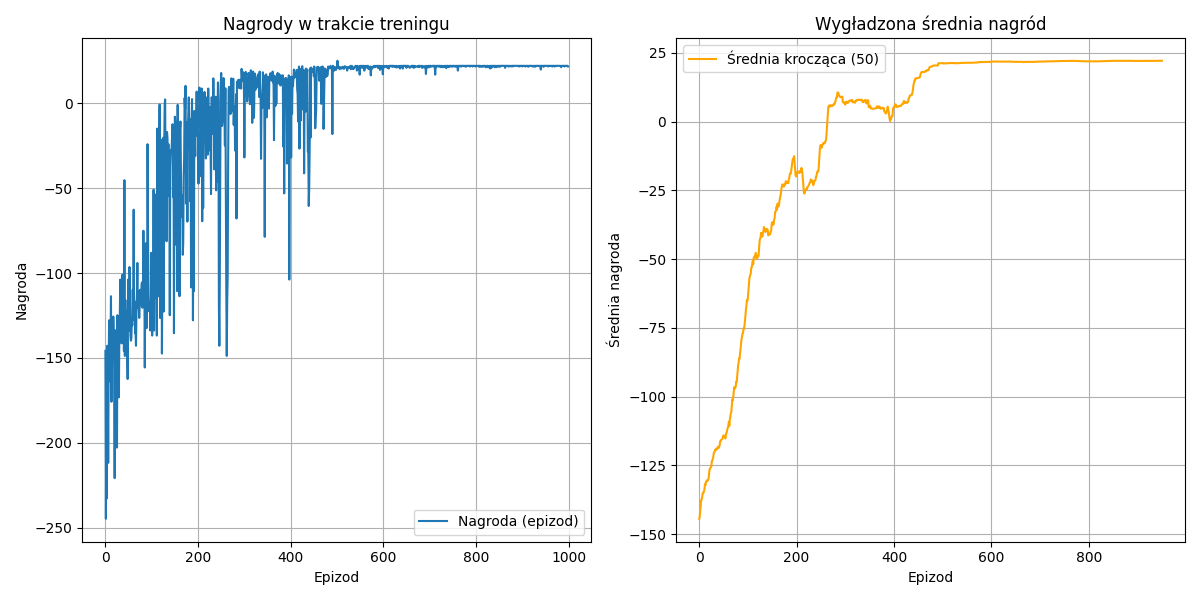

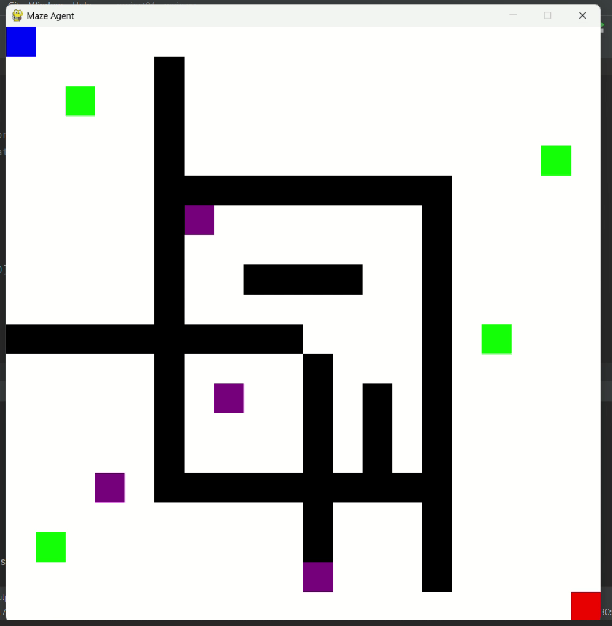